# TP 3: Hasting-Metropolis (and Gibbs) samplers
## Author: Clément Bonnet

---

## Exercise 1: Hasting-Metropolis within Gibbs - Stochastic Approximation EM

## 1.A - A population model for longitudinal data

### 1.

\begin{align*}
    \log q(y,z,\theta) = \
    & C -\frac{1}{2 \sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{ij} - d_i(t_{ij}))^2 - K \log (\sigma) \\
    & -\frac{1}{2 \sigma_\xi} \sum_{i=1}^N \xi_i^2 - \frac{1}{2 \tau_i^2} \sum_{i=1}^N tau_i^2 - N \log(\sigma_\xi) - N \log(\sigma_\tau) \\
    & -\frac{1}{2} \frac{\bar t_o^2}{\sigma_{t_0}^2} - \frac{t_0 \bar t_0}{\sigma_{t_0}} - \frac{1}{2} \frac{\bar v_0^2}{\sigma_{v_0}^2} + \frac{v_0 \bar v_0}{\sigma_{v_0}^2} \\
    & -\frac{1}{2} \frac{\bar t_o^2}{s_{t_0}^2} - \frac{\bar{\bar{t_0}} \bar t_0}{s_{t_0}} - \frac{1}{2} \frac{\bar v_0^2}{s_{v_0}^2} + \frac{\bar{\bar{v_0}} \bar v_0}{s_{v_0}^2} \\
    & -(m+2)\log(\sigma) - \frac{v^2}{2\sigma^2} \\
    & -(m_\tau+2)\log(\sigma_\tau) - \frac{v_\tau^2}{2\sigma_\tau^2} \\
    & -(m_\xi+2)\log(\sigma_\xi) - \frac{v_\xi^2}{2\sigma_\xi^2} \\
\end{align*}
With $K = \sum_i k_i$.

\begin{align*}
    \log q(y,z,\theta) = \langle S(y,z) \,, \phi(\theta) \rangle + \Phi(\theta) + A(x)
\end{align*}

Therefore, the proposed model belongs to the curved exponential family.

### 2.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import invwishart

In [13]:
np.random.seed(0)

# Fixed parameters
N = 50
t_min, t_max = 0, 15
sigma_t0 = 1
sigma_v0 = 1
t0_bar_bar = 0
v0_bar_bar = 0
s_t0 = 0.1
s_v0 = 0.5
# Inverse-Wishart parameters
v, m = 2, 5
v_xi, m_xi = 1, 5
v_tau, m_tau = 2, 5

# Sampled variables
t0_bar    = np.random.normal(t0_bar_bar, s_t0)
v0_bar    = np.random.normal(v0_bar_bar, s_v0)
t0        = np.random.normal(t0_bar, sigma_t0)
v0        = np.random.normal(v0_bar, sigma_v0)
sigma     = np.sqrt(invwishart(df=m, scale=v).rvs())
sigma_xi  = invwishart(df=m_xi, scale=v_xi).rvs()
sigma_tau = invwishart(df=m_tau, scale=v_tau).rvs()
tau       = np.random.normal(0, sigma_tau, size=N)
xi        = np.random.normal(0, sigma_xi, size=N)
alpha     = np.exp(xi)

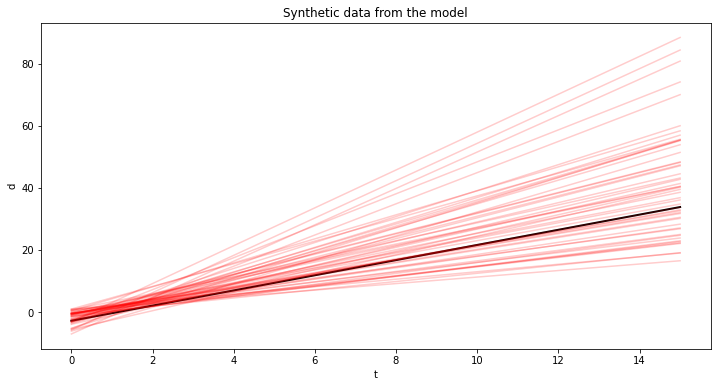

In [14]:
plt.figure(figsize=(12,6));
t = np.linspace(t_min,t_max,10)
d_avg = v0*(t-t0)
d = [v0*(alpha[i]*(t-t0-tau[i]) + t0) -t0 for i in range(N)]

plt.plot(t,d_avg, color="black", linewidth=2);
for i in range(N):
    plt.plot(t, d[i], color="red", alpha=0.2);
plt.title("Synthetic data from the model");
plt.xlabel("t");
plt.ylabel("d");

## 1.B -  HM-SAEM – Hasting-Metropolis sampler

In [15]:
# Sample observations
np.random.seed(0)
obs_ratio = 0.5
t_ij = [np.sort(np.random.choice(np.arange(t_min, t_max), size=np.random.randint(1, obs_ratio*(t_max-t_min+1)), replace=False)) for _ in range(N)]
y = [v0*((alpha[i]*(t_ij[i] - t0 - tau[i]) +t0) - t0) + np.random.normal(0, sigma, size=len(t_ij[i])) for i in range(N)]

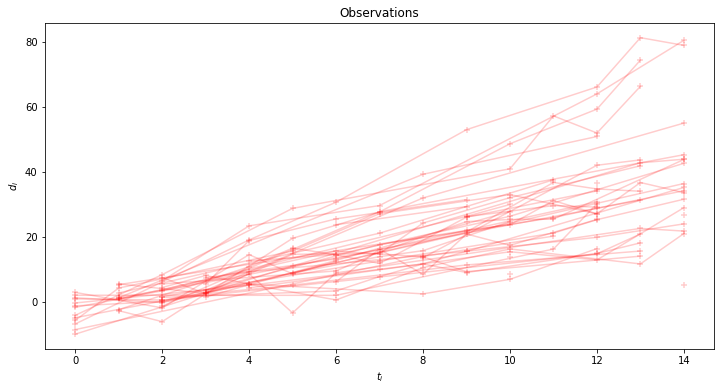

In [16]:
# Plot observations
plt.figure(figsize=(12,6));
for i in range(N):
    plt.scatter(t_ij[i], y[i], alpha=0.2, color="red", marker="+");
    plt.plot(t_ij[i], y[i], alpha=0.2, color="red");
plt.xlabel("$t_i$");
plt.ylabel("$d_i$");
plt.title("Observations");

### HM-SAEM algorithm: Hasting-Metropolis Stochastic Approximation Expectation-Maximization

In [20]:

def saem():
    K = sum([len(y_i) for y_i in y])
    N = len(y)
    S1 = 1/K * sum([np.sum((y[i] - d[i])**2) for i in range(N)])
    S2 = 1/N * np.sum(xi**2)
    S3 = 1/N * np.sum(tau**2)
    S4 = t0
    S5 = v0
    # Maximization
    t0_bar = (S4/sigma_t0**2 + t0_bar_bar/s_t0**2)/(1/sigma_t0**2 + 1/s_t0**2)
    v0_bar = (S5/sigma_v0**2 + v0_bar_bar/s_v0**2)/(1/sigma_v0**2 + 1/s_v0**2)
    sigma = np.sqrt((S1*K + v**2)/(K + m + 2))
    sigma_xi = np.sqrt((S2*N + v_xi**2)/(N + m_xi + 2))
    sigma_tau = np.sqrt((S3*N + v_tau**2)/(N + m_tau + 2))
